In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train_transaction = pd.read_csv(r"C:\Users\ADMIN\ml projects\fraud detection project\fraud detection dataset\train_transaction.csv")
train_identity = pd.read_csv(r"C:\Users\ADMIN\ml projects\fraud detection project\fraud detection dataset\train_identity.csv")
test_transaction = pd.read_csv(r"C:\Users\ADMIN\ml projects\fraud detection project\fraud detection dataset\test_transaction.csv")
test_identity = pd.read_csv(r"C:\Users\ADMIN\ml projects\fraud detection project\fraud detection dataset\test_identity.csv")

In [2]:
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print('Merged train data shape: ', train_df.shape)

Merged train data shape:  (590540, 434)


In [3]:
test_df = test_transaction.merge(test_identity, on='TransactionID', how='left')
print('Merged test data shape: ', test_df.shape)

Merged test data shape:  (506691, 433)


In [4]:
missing_cols = train_df.columns[train_df.isnull().any()]

results = []

for col in missing_cols:
    stats = train_df.groupby(train_df[col].isnull())['isFraud'].mean()
    
    if len(stats) == 2:
        missing_rate = stats[True]
        present_rate = stats[False]
        diff = missing_rate - present_rate
        
        results.append({
            'column': col,
            'fraud_rate_missing': missing_rate,
            'fraud_rate_present': present_rate,
            'absolute_diff': diff
        })

signal_df = pd.DataFrame(results).sort_values(by='absolute_diff', ascending=False)

print(signal_df.head(10))

    column  fraud_rate_missing  fraud_rate_present  absolute_diff
355   V321            0.166667            0.034987       0.131679
354   V320            0.166667            0.034987       0.131679
353   V319            0.166667            0.034987       0.131679
352   V318            0.166667            0.034987       0.131679
343   V309            0.166667            0.034987       0.131679
342   V308            0.166667            0.034987       0.131679
341   V307            0.166667            0.034987       0.131679
344   V310            0.166667            0.034987       0.131679
346   V312            0.166667            0.034987       0.131679
345   V311            0.166667            0.034987       0.131679


In [5]:
to_drop = []
for col in missing_cols:
    missing_pct = train_df[col].isnull().mean()
    sig = signal_df[signal_df['column'] == col]['absolute_diff'].values
    delta = sig[0] if len(sig) > 0 else 0
    
    if missing_pct > 0.90 and abs(delta) < 0.01:
        to_drop.append(col)

train_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)
print(f"Dropped {len(to_drop)} columns with no predictive signal.")

Dropped 0 columns with no predictive signal.


In [6]:
from sklearn.model_selection import train_test_split

x = train_df.drop(columns=['isFraud'])
y = train_df['isFraud']

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
import joblib
import os


BASE_PATH = r"C:\Users\ADMIN\ml projects\fraud detection project\API"

METADATA = joblib.load(os.path.join(BASE_PATH, "lgb_feature_metadata_v2.joblib"))
FEATURE_COLUMNS = METADATA["feature_names"]
CATEGORICAL_FEATURES = METADATA["categorical_features"]
CATEGORICAL_MAPPINGS = METADATA["categorical_mappings"]

MEDIANS = joblib.load(os.path.join(BASE_PATH, "training_medians.joblib"))
CARD1_AMT_MEANS = joblib.load(os.path.join(BASE_PATH, "card1_amt_means.joblib"))
UID_AMT_MEANS = joblib.load(os.path.join(BASE_PATH, "uid_amt_means.joblib"))
UID_D1_MEANS = joblib.load(os.path.join(BASE_PATH, "uid_d1_means.joblib"))
UID_D15_MEANS = joblib.load(os.path.join(BASE_PATH, "uid_d15_means.joblib"))
C_FEATS_MEANS = joblib.load(os.path.join(BASE_PATH, "c_feats_card1_means.joblib"))
CARD1_ADDR_NUNIQUE = joblib.load(os.path.join(BASE_PATH, "card1_addr_nunique.joblib"))

def preprocess_transaction(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = raw_df.copy()

    card1 = df["card1"].iloc[0]
    addr1 = df["addr1"].iloc[0] if "addr1" in df.columns else np.nan
    uid = (card1, addr1)

    df["card1_amt_mean"] = CARD1_AMT_MEANS.get(card1, np.nan)
    df["card1_amt_ratio"] = df["TransactionAmt"] / (df["card1_amt_mean"] + 0.01)
    df["uid_amt_mean"] = UID_AMT_MEANS.get(uid, np.nan)
    df["uid_amt_ratio"] = df["TransactionAmt"] / (df["uid_amt_mean"] + 0.01)
    df["card1_addr1_count"] = CARD1_ADDR_NUNIQUE.get(card1, 1)
    df["uid_D1_mean"] = UID_D1_MEANS.get(uid, np.nan)
    df["uid_D15_mean"] = UID_D15_MEANS.get(uid, np.nan)

    # --- Ensure all categorical columns exist ---
    for col in CATEGORICAL_FEATURES:
        if col not in df.columns:
            df[col] = 'missing'  # create missing column if absent
        allowed = CATEGORICAL_MAPPINGS[col]
        if 'missing' not in allowed:
            allowed = allowed + ['missing']
        df[col] = df[col].astype(str).replace('nan', 'missing')
        df.loc[~df[col].isin(allowed), col] = 'missing'
        df[col] = pd.Categorical(df[col], categories=allowed)

    # --- Final schema alignment ---
    for col in FEATURE_COLUMNS:
        if col not in df.columns:
            df[col] = 0  # numeric fill for missing engineered columns

    df = df[FEATURE_COLUMNS]

    # Fill remaining NaNs with training medians
    for col, median in MEDIANS.items():
        if col in df.columns:
            df[col] = df[col].fillna(median)

    # Ensure numeric types
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].astype('float32')

    return df


In [8]:
x_eval_processed = preprocess_transaction(x_eval)
print(x_eval_processed.shape)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4836\1070356989.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # numeric fill for missing engineered columns
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4836\1070356989.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # numeric fill for missing engineered columns
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4836\1070356989.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

(118108, 555)


In [9]:
import joblib

model = joblib.load(r"C:\Users\ADMIN\ml projects\fraud detection project\models\fraud_model_v2.pkl")

In [10]:
for col in CATEGORICAL_FEATURES:
    if col in x_eval_processed.columns:
        training_categories = CATEGORICAL_MAPPINGS[col]

        x_eval_processed[col] = pd.Categorical(
            x_eval_processed[col].astype(str).replace('nan', 'missing'), 
            categories=training_categories
        )

In [11]:
y_proba = model.predict_proba(x_eval_processed)[:, 1]

y_pred = (y_proba >= 0.35).astype(int)

In [12]:
error_df = x_eval_processed.copy()
error_df['actual'] = y_eval.values
error_df['prediction'] = y_pred
error_df['proba'] = y_proba

# Identify the type of mistake
def get_error_type(row):
    if row['actual'] == 1 and row['prediction'] == 1: return 'TP (Caught)'
    if row['actual'] == 0 and row['prediction'] == 0: return 'TN (Safe)'
    if row['actual'] == 0 and row['prediction'] == 1: return 'FP (Insult)'
    if row['actual'] == 1 and row['prediction'] == 0: return 'FN (Leak)'

error_df['error_category'] = error_df.apply(get_error_type, axis=1)

In [13]:
error_df.head(10)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,C11_ratio,C12_ratio,C13_ratio,C14_ratio,C1_per_Amt,is_new_user,actual,prediction,proba,error_category
470624,3457624.0,12153579.0,724.000000,W,7826.0,481.0,150.0,mastercard,224.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.104991,TN (Safe)
565820,3552820.0,15005886.0,108.500000,W,12544.0,321.0,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.072196,TN (Safe)
284083,3271083.0,6970178.0,47.950001,W,9400.0,111.0,150.0,mastercard,224.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.025328,TN (Safe)
239689,3226689.0,5673658.0,100.598999,C,15885.0,545.0,185.0,visa,138.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.193879,TN (Safe)
281855,3268855.0,6886780.0,107.949997,W,15497.0,490.0,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.011255,TN (Safe)
413908,3400908.0,10444930.0,280.000000,W,7919.0,194.0,150.0,mastercard,166.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.146689,TN (Safe)
413692,3400692.0,10442147.0,311.950012,W,9002.0,453.0,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.022365,TN (Safe)
474182,3461182.0,12254683.0,330.989990,W,14183.0,555.0,150.0,visa,226.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.267171,TN (Safe)
370788,3357788.0,9228284.0,10.392000,C,9633.0,130.0,185.0,visa,138.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.590023,TP (Caught)
28757,3015757.0,739585.0,335.000000,W,11207.0,361.0,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.138462,TN (Safe)


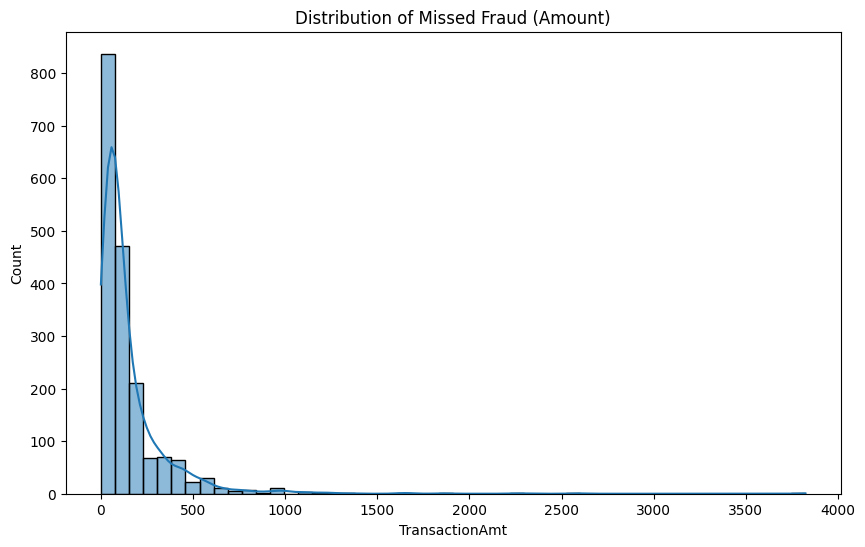

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for only the "Leaks" (False Negatives)
leaks = error_df[error_df['error_category'] == 'FN (Leak)']

plt.figure(figsize=(10, 6))
sns.histplot(data=leaks, x='TransactionAmt', bins=50, kde=True)
plt.title('Distribution of Missed Fraud (Amount)')
plt.show()

In [15]:
small_tx = error_df[error_df['TransactionAmt'] < 100]

small_tx.groupby('error_category')[['C1', 'C13', 'dist1']].mean()

,C1,C13,dist1
error_category,,,
FN (Leak),23.089718,26.413307,53.490929
FP (Insult),21.437162,16.259060,40.833462
TN (Safe),14.968523,36.165874,48.493084
TP (Caught),52.641800,23.081318,19.477823


In [16]:
category_counts = error_df['error_category'].value_counts()
category_pct = error_df['error_category'].value_counts(normalize=True) * 100

print("--- Error Category Distribution ---")
for cat in ['TP (Caught)', 'TN (Safe)', 'FP (Insult)', 'FN (Leak)']:
    count = category_counts.get(cat, 0)
    pct = category_pct.get(cat, 0)
    print(f"{cat}: {count} transactions ({pct:.2f}%)")


--- Error Category Distribution ---
TP (Caught): 2421 transactions (2.05%)
TN (Safe): 111383 transactions (94.31%)
FP (Insult): 2483 transactions (2.10%)
FN (Leak): 1821 transactions (1.54%)


In [17]:
tp = category_counts.get('TP (Caught)', 0)
fp = category_counts.get('FP (Insult)', 0)
fn = category_counts.get('FN (Leak)', 0)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n--- Model Performance Metrics ---")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1_score:.4f}")


--- Model Performance Metrics ---
Precision: 0.4937
Recall:    0.5707
F1-Score:  0.5294


In [18]:
if 'P_emaildomain' not in error_df.columns:
    error_df['P_emaildomain'] = x_eval['P_emaildomain'].values

print("Top domains for 'Insults' (FP):")
fp_emails = error_df[error_df['error_category'] == 'FP (Insult)']['P_emaildomain']
print(fp_emails.value_counts().head(10))

Top domains for 'Insults' (FP):
P_emaildomain
gmail.com        956
hotmail.com      417
yahoo.com        234
anonymous.com    206
aol.com           83
outlook.com       36
comcast.net       34
yahoo.com.mx      15
msn.com           14
icloud.com        13
Name: count, dtype: int64


In [19]:
import lightgbm as lgb

x_train_processed = pd.read_parquet('x_lgb_train.parquet')
y_train = pd.read_parquet('y_lgb_train.parquet')

x_train_processed['C1_per_Amt'] = x_train_processed['C1'] / (x_train_processed['TransactionAmt'] + 1)
x_train_processed['is_new_user'] = (x_train_processed['C13'] <= 1).astype(int)

for col in x_train_processed.select_dtypes(include=['object']).columns:
    x_train_processed[col] = x_train_processed[col].astype('category')


In [20]:
object_cols = x_train_processed.select_dtypes(include=['object']).columns.tolist()

for col in object_cols:
    x_train_processed[col] = x_train_processed[col].astype('category')
    x_eval_processed[col] = x_eval_processed[col].astype('category')

train_data = lgb.Dataset(
    x_train_processed, 
    label=y_train, 
    categorical_feature=object_cols
)

print(f"✅ Success! Prepared {len(object_cols)} categorical features for Optuna.")

✅ Success! Prepared 0 categorical features for Optuna.


In [21]:
!pip install optuna

import optuna
from sklearn.metrics import f1_score

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 3.0, 10.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    }

    model = lgb.train(param, train_data, num_boost_round=100)
    
    proba = model.predict(x_eval_processed)

    preds = (proba >= 0.35).astype(int)
    
    return f1_score(y_eval, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Trial:")
print(study.best_params)

C:\Users\ADMIN\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-01-30 13:02:56,244] A new study created in memory with name: no-name-9e32d4ad-29cb-465e-a2cf-ea4ac9e65c2e
[I 2026-01-30 13:04:07,968] Trial 0 finished with value: 0.49214995193848127 and parameters: {'learning_rate': 0.08857584944683936, 'num_leaves': 142, 'scale_pos_weight': 3.8747148141622585, 'feature_fraction': 0.850992138281371}. Best is trial 0 with value: 0.49214995193848127.
[I 2026-01-30 13:04:42,145] Trial 1 finished with value: 0.4067337185248591 and parameters: {'learning_rate': 0.04663892128409187, 'num_leaves': 79, 'scale_pos_weight': 7.652014288970996, 'feature_fraction': 0.641046300389326}. Best is trial 0 with value: 0.49214995193848127.
[I 2026-01-30 13:05:11,028] Trial 2 finished with value: 0.40673499267935576 and par

Best Trial:
{'learning_rate': 0.03416879752139985, 'num_leaves': 85, 'scale_pos_weight': 3.394127882488612, 'feature_fraction': 0.712811425016529}


In [22]:
import json

best_params = study.best_params

with open('best_params_v3.json', 'w') as f:
    json.dump(best_params, f)

print("✅ Best parameters saved to best_params_v3.json")

✅ Best parameters saved to best_params_v3.json
